In [38]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots,cm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence \
import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
summarize,
poly)
from sklearn.metrics import accuracy_score
from ISLP import confusion_table
from ISLP.models import contrast

import sklearn.model_selection as skm
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
    (RandomForestClassifier as RF,
     GradientBoostingClassifier as GBR)
from ISLP.bart import BART
from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay
roc_curve = RocCurveDisplay.from_estimator
import scipy.stats as stats

In [2]:
train = pd.read_csv("dataset/train.csv")
test = pd.read_csv("dataset/test.csv")

In [3]:
x_train = train[["AI_Interaction_Level", "Satisfaction_with_AI_Services"]]
x_test = test[["AI_Interaction_Level", "Satisfaction_with_AI_Services"]]
y_train =train["Customer_Churn"]
y_test = test["Customer_Churn"]

In [19]:
rbf = SVC(kernel="rbf",gamma=1,C=1)
rbf.fit(x_train,y_train)

SVC(C=1, gamma=1)

c:\Users\30243\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


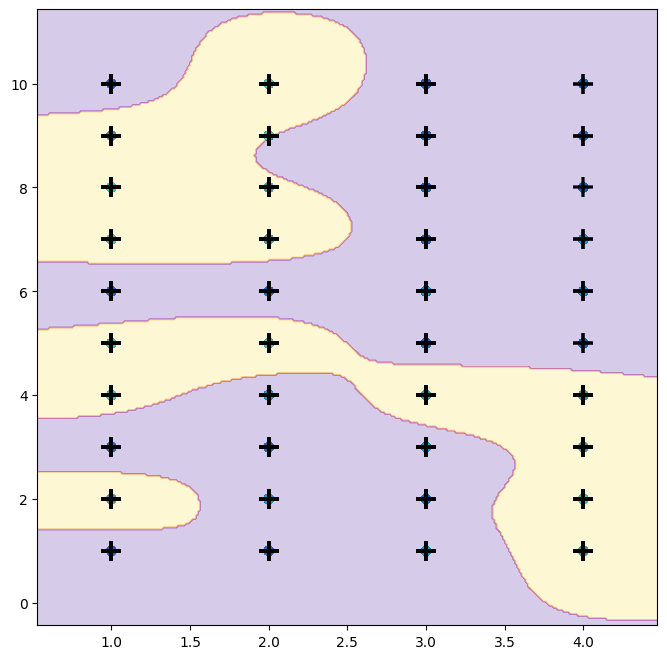

In [20]:
fig ,     ax     =     subplots ( figsize =(8 ,8) ) 
plot_svm (x_train ,
y_train , 
rbf , 
ax = ax )

In [24]:
svm_rbf     =     SVC( kernel ="rbf",gamma=1,C=1e5) 
svm_rbf .fit(x_train ,     y_train )
kfold     =     skm. KFold (5,
random_state =0, 
shuffle =True)
grid     =     skm. GridSearchCV ( svm_rbf ,
{ 'C':[0.1 ,1 ,10 ,100 ,1000] , 
'gamma':[0.5 ,1 ,2 ,3 ,4]} ,
refit =True , 
cv = kfold ,
scoring ='accuracy')
grid .fit( x_train ,     y_train ) 
grid . best_params_

{'C': 0.1, 'gamma': 4}

In [28]:
best_svm     =     grid. best_estimator_
y_hat_test     =     best_svm . predict (x_test ) 
confusion_table (y_hat_test ,     y_test)


Truth,0,1
Predicted,,
0,590,374
1,124,162


In [29]:
accuracy = accuracy_score(y_test, y_hat_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 60.16%


In [39]:
from sklearn.model_selection import RandomizedSearchCV


param_distributions = {
    'C': stats.uniform(0.1, 1000),  # Uniform distribution between 0.1 and 1000.1
    'gamma': stats.uniform(0.5, 3.5)  # Uniform distribution between 0.5 and 4
}
kfold = skm.KFold(5, random_state=0, shuffle=True)
svm_rbf = SVC(kernel='rbf')

random_search = RandomizedSearchCV(
    svm_rbf, 
    param_distributions=param_distributions, 
    n_iter=100,  # Number of parameter settings that are sampled
    cv=kfold, 
    scoring='accuracy', 
    refit=True, 
    random_state=0,
    verbose=2,
    n_jobs=-1
)
random_search.fit(x_train, y_train)
print("Best parameters found: ", random_search.best_params_)

# You can also access the best score directly
print("Best score: ", random_search.best_score_)

# Best estimator (model) after refit
best_model = random_search.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'C': 548.9135039273248, 'gamma': 3.0031627823034683}
Best score:  0.575


In [42]:
svm_new     =     SVC( kernel ="rbf",gamma=3,C=549) 
svm_new .fit(x_train ,     y_train )
y_hat_test     =    svm_new . predict (x_test ) 
confusion_table (y_hat_test ,     y_test)

Truth,0,1
Predicted,,
0,538,306
1,176,230


In [43]:
accuracy = accuracy_score(y_test, y_hat_test)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 61.44%
